In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import requests
%matplotlib inline

In [2]:
from dis import dis

"""
def add_adx(data):
    UpMove = data["High"] - data["High"].shift(1)
    DownMove = data["Low"].shift(1) - data["Low"]
    
    #print("Check :", (UpMove > DownMove) == (UpMove > 0))

    pDM = pd.Series(np.where((UpMove > DownMove) & (UpMove > 0),UpMove,0))
    mDM = pd.Series(np.where((DownMove > UpMove) & (DownMove > 0),DownMove,0))

    display(pDM.loc[pDM.index < 14])
    display(mDM.loc[mDM.index < 14])

    TR = pd.concat([data["High"] - data["Low"], 
    np.abs(data["High"] - data["Close"].shift(1)), 
    np.abs(data["Low"] - data["Close"].shift(1))], axis=1)

    TR = pd.Series(TR.max(axis=1))

    ATR = TR.copy()

    ATR.loc[ATR.index < 14] = TR.loc[TR.index < 14].cumsum()
    ATR.loc[ATR.index < 14] = ATR.loc[ATR.index < 14] / (ATR.index[0:14] + 1)
    ATR.loc[ATR.index >= 14] = TR.loc[TR.index >= 14].rolling(14).mean()


    #display(ATR[ATR.index < 14])

    SpDM = (13 / 14) * pDM.rolling(14).sum() + (1 / 14) * pDM
    SmDM = (13 / 14) * mDM.rolling(14).sum() + (1 / 14) * mDM

    pDI = 100 * SpDM / ATR
    mDI = 100 * SmDM / ATR

    display(pDI.loc[pDI.index < 14])
    display(mDI.loc[mDI.index < 14])

    DX = 100 * np.abs(pDI - mDI) / np.abs(pDI + mDI)

    #display(DX.value_counts())
    display(DX.loc[DX.index < 14])

    data["ADX"] = 0
    
    data.loc[data.index < 14,"ADX"] = DX.loc[data.index < 14].cumsum()
    #display(data["ADX"].value_counts())
    data["ADX"] = data["ADX"] / (data.index + 1)
    
    display(data["ADX"])
    
    data.loc[data.index >= 14, "ADX"] = 13 * data.loc[np.where(data.index >= 14),"ADX"].shift(1) + data.loc[np.where(data.index >= 14),"ADX"]
    data.loc[data.index >= 14, "ADX"] = data.loc[data.index >= 14, "ADX"] / 14
    display(data["ADX"].value_counts())
    #for index,row in data.iterrows():
    #    data.loc[index < 14,"ADX"] = data.loc[0:index,"ADX"] / (index + 1)
    #    data.loc[index >= 14, "ADX"] = 13 * data.loc[index-1,"ADX"] + data.loc[index,"ADX"]


    return data
"""

'\ndef add_adx(data):\n    UpMove = data["High"] - data["High"].shift(1)\n    DownMove = data["Low"].shift(1) - data["Low"]\n    \n    #print("Check :", (UpMove > DownMove) == (UpMove > 0))\n\n    pDM = pd.Series(np.where((UpMove > DownMove) & (UpMove > 0),UpMove,0))\n    mDM = pd.Series(np.where((DownMove > UpMove) & (DownMove > 0),DownMove,0))\n\n    display(pDM.loc[pDM.index < 14])\n    display(mDM.loc[mDM.index < 14])\n\n    TR = pd.concat([data["High"] - data["Low"], \n    np.abs(data["High"] - data["Close"].shift(1)), \n    np.abs(data["Low"] - data["Close"].shift(1))], axis=1)\n\n    TR = pd.Series(TR.max(axis=1))\n\n    ATR = TR.copy()\n\n    ATR.loc[ATR.index < 14] = TR.loc[TR.index < 14].cumsum()\n    ATR.loc[ATR.index < 14] = ATR.loc[ATR.index < 14] / (ATR.index[0:14] + 1)\n    ATR.loc[ATR.index >= 14] = TR.loc[TR.index >= 14].rolling(14).mean()\n\n\n    #display(ATR[ATR.index < 14])\n\n    SpDM = (13 / 14) * pDM.rolling(14).sum() + (1 / 14) * pDM\n    SmDM = (13 / 14) * mDM

In [11]:
def add_adx(df: pd.DataFrame(), interval: int=14):
  df['-DM'] = df['Low'].shift(1) - df['Low']
  df['+DM'] = df['High'] - df['High'].shift(1)
  df['+DM'] = np.where((df['+DM'] > df['-DM']) & (df['+DM']>0), df['+DM'], 0.0)
  df['-DM'] = np.where((df['-DM'] > df['+DM']) & (df['-DM']>0), df['-DM'], 0.0)
  df['TR_TMP1'] = df['High'] - df['Low']
  if "Adj Close" in df.columns:
    df['TR_TMP2'] = np.abs(df['High'] - df['Adj Close'].shift(1))
    df['TR_TMP3'] = np.abs(df['Low'] - df['Adj Close'].shift(1))
  else:
    df['TR_TMP2'] = np.abs(df['High'] - df['Close'].shift(1))
    df['TR_TMP3'] = np.abs(df['Low'] - df['Close'].shift(1))
  df['TR'] = df[['TR_TMP1', 'TR_TMP2', 'TR_TMP3']].max(axis=1)
  df['TR'+str(interval)] = df['TR'].rolling(interval).sum()
  df['+DMI'+str(interval)] = df['+DM'].rolling(interval).sum()
  df['-DMI'+str(interval)] = df['-DM'].rolling(interval).sum()
  df['+DI'+str(interval)] = df['+DMI'+str(interval)] /   df['TR'+str(interval)]*100
  df['-DI'+str(interval)] = df['-DMI'+str(interval)] / df['TR'+str(interval)]*100
  df['DI'+str(interval)+'-'] = abs(df['+DI'+str(interval)] - df['-DI'+str(interval)])
  df['DI'+str(interval)] = df['+DI'+str(interval)] + df['-DI'+str(interval)]
  df['DX'] = (df['DI'+str(interval)+'-'] / df['DI'+str(interval)])*100
  df['ADX'+str(interval)] = df['DX'].rolling(interval).mean()
  df['ADX'+str(interval)] =   df['ADX'+str(interval)].fillna(df['ADX'+str(interval)].mean())
  del df['TR_TMP1'], df['TR_TMP2'], df['TR_TMP3'], df['TR'], df['TR'+str(interval)]
  del df['+DMI'+str(interval)], df['DI'+str(interval)+'-']
  del df['DI'+str(interval)], df['-DMI'+str(interval)]
  del df['+DI'+str(interval)], df['-DI'+str(interval)]
  del df['DX']
  return df

In [12]:
def fear_and_greed():

    URL = "https://api.alternative.me/fng/?limit=0"
    r = requests.get(url = URL)
    fng = r.json()
    fng = pd.DataFrame(fng['data'])
    fng["timestamp"] = fng["timestamp"].astype(int)
    fng["value"] = fng["value"].astype(int)
    for index,row in fng.iterrows():
        fng.loc[index,"timestamp"] = datetime.utcfromtimestamp(fng.loc[index,"timestamp"])
        fng.loc[index,"timestamp"] = fng.loc[index,"timestamp"].strftime("%Y-%m-%d")
    fng.rename(columns={"timestamp":"Date", "value":"FnG"},inplace=True)

    return fng.drop(["time_until_update","value_classification"],axis=1)
fear_and_greed()

NameError: name 'requests' is not defined

In [13]:
def add_rsi(data):
    df = data.copy()

    df["Gains"] = df["Variation"] * (df["Variation"] >= 0)
    df["Losses"] = df["Variation"] * (df["Variation"] < 0)
    df["Avg Gain"] = df["Gains"].rolling(14).mean()
    df["Avg Loss"] = df["Losses"].rolling(14).mean()
    for i in range(14):
        df["Avg Gain"].loc[i] = df["Gains"][0:i].mean()
        df["Avg Loss"].loc[i] = df["Losses"][0:i].mean()

    df["Avg Loss"] = -1 * df["Avg Loss"]

    df['RSI'] = 0

    #df['RSI'] = 100 - (100 / (1 + ))
    
    df['RSI'] = 100 - (100 / (1 + df['Avg Gain'] / df['Avg Loss']))

    df = df.drop(["Gains", "Losses", "Avg Gain", "Avg Loss"],axis=1)

    #df['RSI'].loc[0:14] = 100 - (100 / (1 + df['Avg Gain'].loc[0:14] / df['Avg Loss'].loc[0:14]))


    return df

In [14]:
def add_macd(data):
    df = data.copy()

    df['MACD'] = df["Close"].ewm(span=12, adjust=False).mean() - df["Close"].ewm(span=26, adjust=False).mean()

    df['MACD_SIGNAL'] = df["MACD"].ewm(span=9, adjust=False).mean()

    df['MACD_H'] = df["MACD"] - df["MACD_SIGNAL"]

    df.drop(["MACD_SIGNAL"], axis=1, inplace=True)

    return df

In [7]:
confirmation = pd.read_csv("median-confirmation-time.csv")
confirmation

,Timestamp,median-confirmation-time
0,2009-01-09 23:00:00,0.000000
1,2009-01-12 23:00:00,0.000000
2,2009-01-15 23:00:00,0.000000
3,2009-01-18 23:00:00,0.000000
4,2009-01-21 23:00:00,0.000000
...,...,...
1661,2022-09-02 00:00:00,6.300595
1662,2022-09-05 00:00:00,7.164286
1663,2022-09-08 00:00:00,7.404167
1664,2022-09-11 00:00:00,6.991071


In [8]:
time = confirmation.loc[0,"Timestamp"]
time[:-9]

'2009-01-09'

In [9]:
def confirmation_time(data):
    df = pd.DataFrame({"Date":[],"Confirmation Time":[]})
    for i in range(len(data)):
        for j in range(3):
            date = datetime.strptime(data.loc[i,"Timestamp"][:-9],"%Y-%m-%d")
            date = date + timedelta(days=j)
            #print(str(date)[:-9])
            df = df.append({"Date":str(date)[:-9],"Confirmation Time":data.loc[i,"median-confirmation-time"]},ignore_index=True)
    return df

In [10]:
transactions = pd.read_csv("n-transactions.csv")
transactions

,Timestamp,n-transactions
0,2009-01-16 23:00:00,109
1,2009-01-19 23:00:00,115
2,2009-01-22 23:00:00,86
3,2009-01-25 23:00:00,97
4,2009-01-28 23:00:00,122
...,...,...
1659,2022-09-03 00:00:00,242597
1660,2022-09-06 00:00:00,268125
1661,2022-09-09 00:00:00,290849
1662,2022-09-12 00:00:00,268971


In [11]:
def network_transactions(data):
    df = pd.DataFrame({"Date":[], "Transactions":[]})

    for i in range(len(data)):
        for j in range(3):
            date = datetime.strptime(data.loc[i,"Timestamp"][:-9],"%Y-%m-%d")
            date = date + timedelta(days=j)
            #print(str(date)[:-9])
            df = df.append({"Date":str(date)[:-9],"Transactions":data.loc[i,"n-transactions"]},ignore_index=True)
    return df

In [12]:
def miners_revenue(data):
    df = pd.DataFrame({"Date":[], "Miners Revenue":[]})

    for i in range(len(data)):
        for j in range(3):
            date = datetime.strptime(data.loc[i,"Timestamp"][:-9],"%Y-%m-%d")
            date = date + timedelta(days=j)
            df = df.append({"Date":str(date)[:-9],"Miners Revenue":data.loc[i,"miners-revenue"]},ignore_index=True)

    return df

In [15]:
def standardize_col(data,col):
    df = data.copy()
    df[col] = (df[col] - df[col].mean()) / df[col].std()
    return df

In [14]:
data = pd.read_csv("BTC-USD_.csv")
data = add_adx(data)
data

,Date,Open,High,Low,Close,Adj Close,Volume,-DM,+DM,ADX14
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,2.105680e+07,0.000000,0.0,42.068597
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,3.448320e+07,39.317993,0.0,42.068597
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,3.791970e+07,28.571991,0.0,42.068597
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,3.686360e+07,0.000000,0.0,42.068597
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,2.658010e+07,0.000000,0.0,42.068597
...,...,...,...,...,...,...,...,...,...,...
2911,2022-09-06,19817.724609,20155.269531,18800.171875,18837.667969,18837.667969,4.340398e+10,872.875000,0.0,56.076632
2912,2022-09-07,18837.683594,19427.171875,18644.466797,19290.324219,19290.324219,3.523976e+10,155.705078,0.0,57.976239
2913,2022-09-08,19289.941406,19417.351563,19076.714844,19329.833984,19329.833984,3.219448e+10,0.000000,0.0,58.507658
2914,2022-09-09,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,42.068597


<AxesSubplot:>

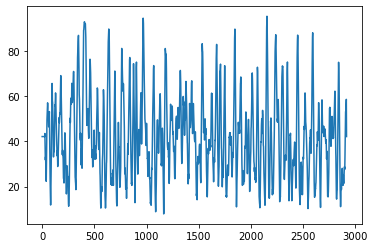

In [15]:
data["ADX14"].plot()

In [16]:
data = pd.read_csv("BTC-USD_.csv")
data["Variation"] = (data["Close"] - data["Close"].shift(1)) / data["Close"].shift(1)
data = add_rsi(data)
data = add_macd(data)
data = add_adx(data)
data.drop("Adj Close",axis=1,inplace=True)
data = standardize_col(data,"Volume")
data = standardize_col(data,"MACD")
data = standardize_col(data,"MACD_H")
data = standardize_col(data,"RSI")
data = standardize_col(data,"Variation")
data = standardize_col(data, ["ADX14", "-DM", "+DM"])
confirmation = confirmation_time(pd.read_csv("median-confirmation-time.csv"))
transactions = network_transactions(pd.read_csv("n-transactions.csv"))
miners_revenue = miners_revenue(pd.read_csv("miners-revenue.csv"))
fear_and_greed = fear_and_greed()
data = pd.merge(data,confirmation,on="Date")
data = pd.merge(data,transactions,on="Date")
data = pd.merge(data,miners_revenue,on="Date")
data = pd.merge(data,fear_and_greed,on="Date")
data = standardize_col(data,"Confirmation Time")
data = standardize_col(data,"Transactions")
data = standardize_col(data,"Miners Revenue")
data = standardize_col(data,"FnG")
data.dropna(inplace=True)

c:\Users\user\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


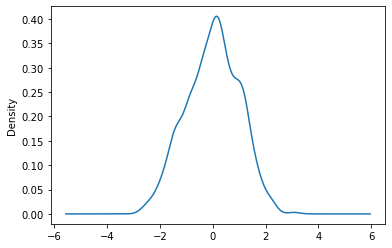

In [17]:
data["Transactions"].plot.kde()
plt.show()

In [18]:
data

,Date,Open,High,Low,Close,Volume,Variation,RSI,MACD,MACD_H,-DM,+DM,ADX14,Confirmation Time,Transactions,Miners Revenue,FnG
0,2018-02-01,10237.299805,10288.799805,8812.280273,9170.540039,-0.292146,-2.712213,-1.043523,-1.108359,-0.475907,1.319161,-0.323408,0.521410,1.144750,-0.774692,-0.186892,-0.583209
1,2018-02-02,9142.280273,9142.280273,7796.490234,8830.750000,-0.152676,-1.011481,-1.204172,-1.202571,-0.654534,1.402518,-0.323408,0.393472,1.144750,-0.774692,-0.186892,-1.244407
2,2018-02-03,8852.120117,9430.750000,8251.629883,9174.910156,-0.427993,0.955604,-1.632900,-1.235294,-0.618233,-0.269198,0.287977,0.409785,1.114249,-0.774692,-0.186892,-0.142410
3,2018-02-04,9175.700195,9334.870117,8031.220215,8277.009766,-0.437581,-2.584947,-1.626830,-1.320379,-0.741794,0.093536,-0.323408,0.427573,1.114249,-1.144752,-0.264496,-0.847688
4,2018-02-05,8270.540039,8364.839844,6756.680176,6955.270020,-0.326118,-4.184569,-1.814295,-1.479953,-1.057732,1.828350,-0.323408,0.462483,1.114249,-1.144752,-0.264496,-1.420727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1679,2022-09-04,19832.470703,19999.689453,19636.816406,19986.712891,0.478227,0.148948,-1.113287,-0.844382,-0.254845,-0.167922,-0.323408,0.699748,-1.063067,-0.648298,-0.307825,-1.024008
1680,2022-09-05,19988.789063,20031.160156,19673.046875,19812.371094,0.658018,-0.278482,-1.133325,-0.831832,-0.166540,-0.269198,-0.256709,0.691814,-0.742360,-0.648298,-0.307825,-0.891768
1681,2022-09-06,19817.724609,20155.269531,18800.171875,18837.667969,1.393318,-1.325705,-1.548973,-0.892284,-0.308652,1.167318,-0.323408,0.776149,-0.742360,-0.165203,-0.359746,-0.935848
1682,2022-09-07,18837.683594,19427.171875,18644.466797,19290.324219,0.981876,0.568952,-1.180050,-0.893278,-0.249058,-0.012950,-0.323408,0.881401,-0.742360,-0.165203,-0.359746,-0.847688


In [19]:
data.to_csv("BTC-USD_SIGNALS.csv",index=False)

## 1 minute data processing

In [20]:

data2017 = pd.read_csv("minute_data/BTC-2017min.csv")
data2018 = pd.read_csv("minute_data/BTC-2018min.csv")
data2019 = pd.read_csv("minute_data/BTC-2019min.csv")
data2020 = pd.read_csv("minute_data/BTC-2020min.csv")
data2021 = pd.read_csv("minute_data/BTC-2021min.csv")

data_by_minute = pd.concat([data2017, data2018, data2019, data2020, data2021], axis=0)
#data_by_minute = data_by_minute.sort_values(by="Unix", ascending=True, inplace=False) # ??????????????????!?!¿!?¿!?¿!?¿!?¿!?!¿?!¿?!¿?¿!?¿!?¿!?¿
data_by_minute.to_csv("minute_data/BTC-USD_1m.csv", index=False)


In [21]:
data_by_minute

,Unix,Date,Symbol,Open,High,Low,Close,Volume BTC,Volume USD
0,1514764740,2017-12-31 23:59:00,BTC/USD,13913.28,13913.28,13867.18,13880.00,0.591748,8213.456549
1,1514764680,2017-12-31 23:58:00,BTC/USD,13913.26,13953.83,13884.69,13953.77,1.398784,19518.309658
2,1514764620,2017-12-31 23:57:00,BTC/USD,13908.73,13913.26,13874.99,13913.26,0.775012,10782.944294
3,1514764560,2017-12-31 23:56:00,BTC/USD,13827.00,13908.69,13827.00,13859.58,0.666459,9236.841134
4,1514764500,2017-12-31 23:55:00,BTC/USD,13825.05,13825.05,13825.05,13825.05,0.065501,905.560130
...,...,...,...,...,...,...,...,...,...
610777,1609459500,2021-01-01 00:05:00,BTC/USD,29021.86,29023.38,28982.33,28999.50,1.062360,30807.899250
610778,1609459440,2021-01-01 00:04:00,BTC/USD,29048.13,29057.73,29035.61,29045.19,1.446538,42014.959434
610779,1609459380,2021-01-01 00:03:00,BTC/USD,29037.68,29069.39,29019.00,29048.13,2.189621,63604.382387
610780,1609459320,2021-01-01 00:02:00,BTC/USD,29069.80,29073.02,29028.14,29035.89,3.030301,87987.499279


In [22]:
data = pd.read_csv("minute_data/BTC-USD_1m.csv")
data["Variation"] = (data["Close"] - data["Close"].shift(1)) / data["Close"].shift(1)
data = add_rsi(data)
data = add_macd(data)
data = add_adx(data)
#data.drop("Adj Close",axis=1,inplace=True)
data = standardize_col(data,"Volume USD")
data = standardize_col(data,"MACD")
data = standardize_col(data,"MACD_H")
data = standardize_col(data,"RSI")
data = standardize_col(data,"Variation")
data = standardize_col(data, ["ADX14", "-DM", "+DM"])
'''
confirmation = confirmation_time(pd.read_csv("median-confirmation-time.csv"))
transactions = network_transactions(pd.read_csv("n-transactions.csv"))
miners_revenue = miners_revenue(pd.read_csv("miners-revenue.csv"))
fear_and_greed = fear_and_greed()
data = pd.merge(data,confirmation,on="Date")
data = pd.merge(data,transactions,on="Date")
data = pd.merge(data,miners_revenue,on="Date")
data = pd.merge(data,fear_and_greed,on="Date")
data = standardize_col(data,"Confirmation Time")
data = standardize_col(data,"Transactions")
data = standardize_col(data,"Miners Revenue")
data = standardize_col(data,"FnG")
'''
data.drop(["Volume BTC"], axis=1, inplace=True)
data.dropna(inplace=True)
data.sort_values(by="Unix", ascending=True, inplace=True)

c:\Users\user\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [23]:
data.to_csv("minute_data/BTC-USD_1M_SIGNALS.csv", index=False)

In [24]:
data

,Unix,Date,Symbol,Open,High,Low,Close,Volume USD,Variation,RSI,MACD,MACD_H,-DM,+DM,ADX14
525598,1483228860,2017-01-01 00:01:00,BTC/USD,966.34,966.34,966.34,966.34,-0.312459,-0.006352,-0.241664,0.003268,0.001095,-0.296745,-0.163178,-0.614737
525597,1483228920,2017-01-01 00:02:00,BTC/USD,966.16,966.37,966.16,966.37,-0.310186,-0.000855,0.676875,0.003534,0.002246,-0.285351,-0.163178,-0.664197
525596,1483228980,2017-01-01 00:03:00,BTC/USD,966.37,966.37,966.37,966.37,-0.348678,-0.000855,0.676875,0.003738,0.003484,-0.296745,-0.163178,-0.643473
525595,1483229040,2017-01-01 00:04:00,BTC/USD,966.37,966.37,966.37,966.37,-0.348678,-0.011849,0.682925,0.003932,0.004996,-0.293490,-0.163178,-0.645875
525594,1483229100,2017-01-01 00:05:00,BTC/USD,966.43,966.43,966.43,966.43,-0.348169,-0.028336,0.744369,0.004110,0.006831,-0.288606,-0.163178,-0.648277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2064523,1646105880,2022-03-01 03:38:00,BTC/USD,43077.82,43077.82,43049.46,43049.46,-0.343969,0.205143,2.657823,202.140130,315.950658,-0.296745,1.189788,0.568915
2064522,1646105940,2022-03-01 03:39:00,BTC/USD,43035.16,43035.16,42999.44,42999.44,-0.174815,-0.069151,2.657242,182.098937,328.738652,0.603408,-0.163178,0.177030
2064521,1646106000,2022-03-01 03:40:00,BTC/USD,43022.24,43022.24,43016.03,43016.03,-0.346723,-0.126531,2.657241,153.986631,318.063305,-0.177376,-0.163178,-0.187756
2064520,1646106060,2022-03-01 03:41:00,BTC/USD,43018.23,43046.59,43018.23,43046.58,-0.318365,-0.000855,2.657987,115.826724,271.530088,1.241492,-0.163178,-0.535597


## Dollar Sampling

In [1]:
import pandas as pd
import numpy as np

In [2]:
dollar_data = pd.DataFrame(columns=["Unix", "Date", "Open", "High", "Low", "Close"])
dollar_threshold = 5e5
open = []
high = []
low = []
close = []
date = []
unix = []
dollar_count = 0

In [3]:
data_by_minute = pd.read_csv("minute_data/BTC-USD_1m.csv")
data_by_minute.sort_values(by="Unix", ascending=True, inplace=True)
data_by_minute.reset_index(drop=True, inplace=True)
data_by_minute

,Unix,Date,Symbol,Open,High,Low,Close,Volume BTC,Volume USD
0,1483228860,2017-01-01 00:01:00,BTC/USD,966.34,966.34,966.34,966.34,7.610000,7353.847400
1,1483228920,2017-01-01 00:02:00,BTC/USD,966.16,966.37,966.16,966.37,8.087376,7815.397864
2,1483228980,2017-01-01 00:03:00,BTC/USD,966.37,966.37,966.37,966.37,0.000000,0.000000
3,1483229040,2017-01-01 00:04:00,BTC/USD,966.37,966.37,966.37,966.37,0.000000,0.000000
4,1483229100,2017-01-01 00:05:00,BTC/USD,966.43,966.43,966.43,966.43,0.107000,103.408010
...,...,...,...,...,...,...,...,...,...
2675296,1646105880,2022-03-01 03:38:00,BTC/USD,43077.82,43077.82,43049.46,43049.46,0.022210,956.143143
2675297,1646105940,2022-03-01 03:39:00,BTC/USD,43035.16,43035.16,42999.44,42999.44,0.820950,35300.390268
2675298,1646106000,2022-03-01 03:40:00,BTC/USD,43022.24,43022.24,43016.03,43016.03,0.009230,397.037957
2675299,1646106060,2022-03-01 03:41:00,BTC/USD,43018.23,43046.59,43018.23,43046.58,0.142977,6154.673021


In [4]:
new_candle = True
current_high = -np.inf
current_low = np.inf
current_open = 0
current_unix = None
current_date = None
for index, row in data_by_minute.iterrows():

    if index % 1000 == 0:
        print("index : {}".format(index), end='\r')

    i_high = data_by_minute.loc[index, "High"]
    i_low = data_by_minute.loc[index, "Low"]

    if new_candle:
        current_open = data_by_minute.loc[index, "Open"]
        current_high = i_high
        current_low = i_low
        current_date = data_by_minute.loc[index, "Date"]
        current_unix = data_by_minute.loc[index, "Unix"]
        new_candle = False

    if current_high < i_high:
        current_high = i_high

    if current_low > i_low:
        current_low = i_low

    dollar_count += data_by_minute.loc[index, "Volume USD"]
    if dollar_count >= dollar_threshold:
        dollar_count = dollar_threshold - dollar_count
        new_candle = True
        open.append(current_open)
        close.append(data_by_minute.loc[index, "Close"])
        high.append(current_high)
        low.append(current_low)
        date.append(current_date)
        unix.append(current_unix)

In [5]:
dollar_data["Unix"] = unix
dollar_data["Date"] = date
dollar_data["High"] = high
dollar_data["Low"] = low
dollar_data["Open"] = open
dollar_data["Close"] = close

In [6]:
dollar_data

,Unix,Date,Open,High,Low,Close
0,1483228860,2017-01-01 00:01:00,966.34,966.99,960.53,964.00
1,1483249380,2017-01-01 05:43:00,964.00,975.00,963.74,975.00
2,1483269300,2017-01-01 11:15:00,974.99,975.80,972.50,974.07
3,1483279320,2017-01-01 14:02:00,974.07,978.22,973.20,977.91
4,1483287120,2017-01-01 16:12:00,976.77,984.12,976.22,984.12
...,...,...,...,...,...,...
206017,1646099520,2022-03-01 01:52:00,43436.20,43436.20,43271.46,43273.95
206018,1646099880,2022-03-01 01:58:00,43273.95,43325.97,43128.12,43139.57
206019,1646100600,2022-03-01 02:10:00,43109.61,43174.93,42940.42,43009.25
206020,1646100960,2022-03-01 02:16:00,42998.08,43247.75,42998.08,43154.82


In [7]:
dollar_data.to_csv("dollar_data/dollar_data.csv", index=False)

In [17]:
data = pd.read_csv("dollar_data/dollar_data.csv")
data["Variation"] = (data["Close"] - data["Close"].shift(1)) / data["Close"].shift(1)
data = add_rsi(data)
data = add_macd(data)
data = add_adx(data)
#data.drop("Adj Close",axis=1,inplace=True)
data = standardize_col(data,"MACD")
data = standardize_col(data,"MACD_H")
data = standardize_col(data,"RSI")
data = standardize_col(data,"Variation")
data = standardize_col(data, ["ADX14", "-DM", "+DM"])
'''
confirmation = confirmation_time(pd.read_csv("median-confirmation-time.csv"))
transactions = network_transactions(pd.read_csv("n-transactions.csv"))
miners_revenue = miners_revenue(pd.read_csv("miners-revenue.csv"))
fear_and_greed = fear_and_greed()
data = pd.merge(data,confirmation,on="Date")
data = pd.merge(data,transactions,on="Date")
data = pd.merge(data,miners_revenue,on="Date")
data = pd.merge(data,fear_and_greed,on="Date")
data = standardize_col(data,"Confirmation Time")
data = standardize_col(data,"Transactions")
data = standardize_col(data,"Miners Revenue")
data = standardize_col(data,"FnG")
'''
data.dropna(inplace=True)
#data.drop("Unnamed: 0", axis=1, inplace=True)
#data.sort_values(by="Unix", ascending=True, inplace=True)

c:\Users\user\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [18]:
data.to_csv("dollar_data/dollar_data_SIGNALS.csv", index=False)